<a href="https://colab.research.google.com/github/ZhuRuoyu/computer-vision-waste-classification/blob/main/Waste_Classification_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# data description
https://www.kaggle.com/datasets/mostafaabla/garbage-classification

- 12 classes
- 15,150 images
- some examples: ...

# data prep

- data augmentation: create more samples for minority classes
- `split-folders` load train/test dataset




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
!pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary #model summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install split-folders
import splitfolders
import os

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Humber AI ML/AIGC5502 - Image Processing CV/Final Project

/content/drive/MyDrive/Humber AI ML/AIGC5502 - Image Processing CV/Final Project


# Data Prep

We will need to split the data into training and validation sets. For the training set, we will use transformer and weighted random sampling to augment the data and balance the classes.

In [ ]:
# folder name: garbage_classification

splitfolders.ratio('garbage_classification', output = 'output', seed = 2013,
                   ratio = (0.8, 0.2), group_prefix = None, move = False)



Copying files: 0 files [00:00, ? files/s]

Copying files: 1 files [00:00,  7.44 files/s]

Copying files: 12 files [00:00, 58.51 files/s]

Copying files: 24 files [00:00, 77.11 files/s]

Copying files: 40 files [00:00, 104.67 files/s]

Copying files: 54 files [00:00, 113.43 files/s]

Copying files: 68 files [00:00, 117.89 files/s]

Copying files: 83 files [00:00, 125.61 files/s]

Copying files: 96 files [00:00, 124.89 files/s]

Copying files: 110 files [00:01, 128.61 files/s]

Copying files: 123 files [00:01, 125.64 files/s]

Copying files: 136 files [00:01, 121.35 files/s]

Copying files: 149 files [00:01, 121.82 files/s]

Copying files: 163 files [00:01, 120.03 files/s]

Copying files: 176 files [00:01, 121.07 files/s]

Copying files: 189 files [00:01, 119.71 files/s]

Copying files: 202 files [00:01, 121.76 files/s]

Copying files: 215 files [00:01, 123.89 files/s]

Copying files: 228 files [00:01, 124.25 files/s]

Copying files: 244 files [00:02, 132.45 files/s]

Copying files: 25

In [ ]:
transform_vgg = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.2),
                                    transforms.RandomRotation(degrees=(-20,20))])

In [ ]:
train_data = datasets.ImageFolder('output/train', transform = transform_vgg)
test_data = datasets.ImageFolder('output/val', transform = transform_vgg)

In [ ]:
train_loader = DataLoader(train_data, batch_size = 64, sampler = ImbalancedDatasetSampler(train_data),  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 64, shuffle=True,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(f'{len(class_names)} classes: {class_names}')
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

12 classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Training images available: 12417
Testing images available:  3108


In [ ]:
for images,labels in train_loader:
    break
images.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([64, 3, 224, 224])

In [ ]:
torch.unique(labels, return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 tensor([3, 6, 4, 7, 4, 3, 5, 9, 6, 6, 5, 6]))

Label: [ 7  7  5  7 11  2 10 11  9  4  6 10  3  8  1 10  3  3  3  2  3 10 11  1
  0  8  6  8  9  3  8 11  7  1  3  7  9  5  1  7  8  6  0  9  4 11  0  2
  7  2  5  9  1  9  7 10 11  4  6  4  6  8  1  7]
Class: paper paper green-glass paper white-glass brown-glass trash white-glass shoes clothes metal trash cardboard plastic biological trash cardboard cardboard cardboard brown-glass cardboard trash white-glass biological battery plastic metal plastic shoes cardboard plastic white-glass paper biological cardboard paper shoes green-glass biological paper plastic metal battery shoes clothes white-glass battery brown-glass paper brown-glass green-glass shoes biological shoes paper trash white-glass clothes metal clothes metal plastic biological paper


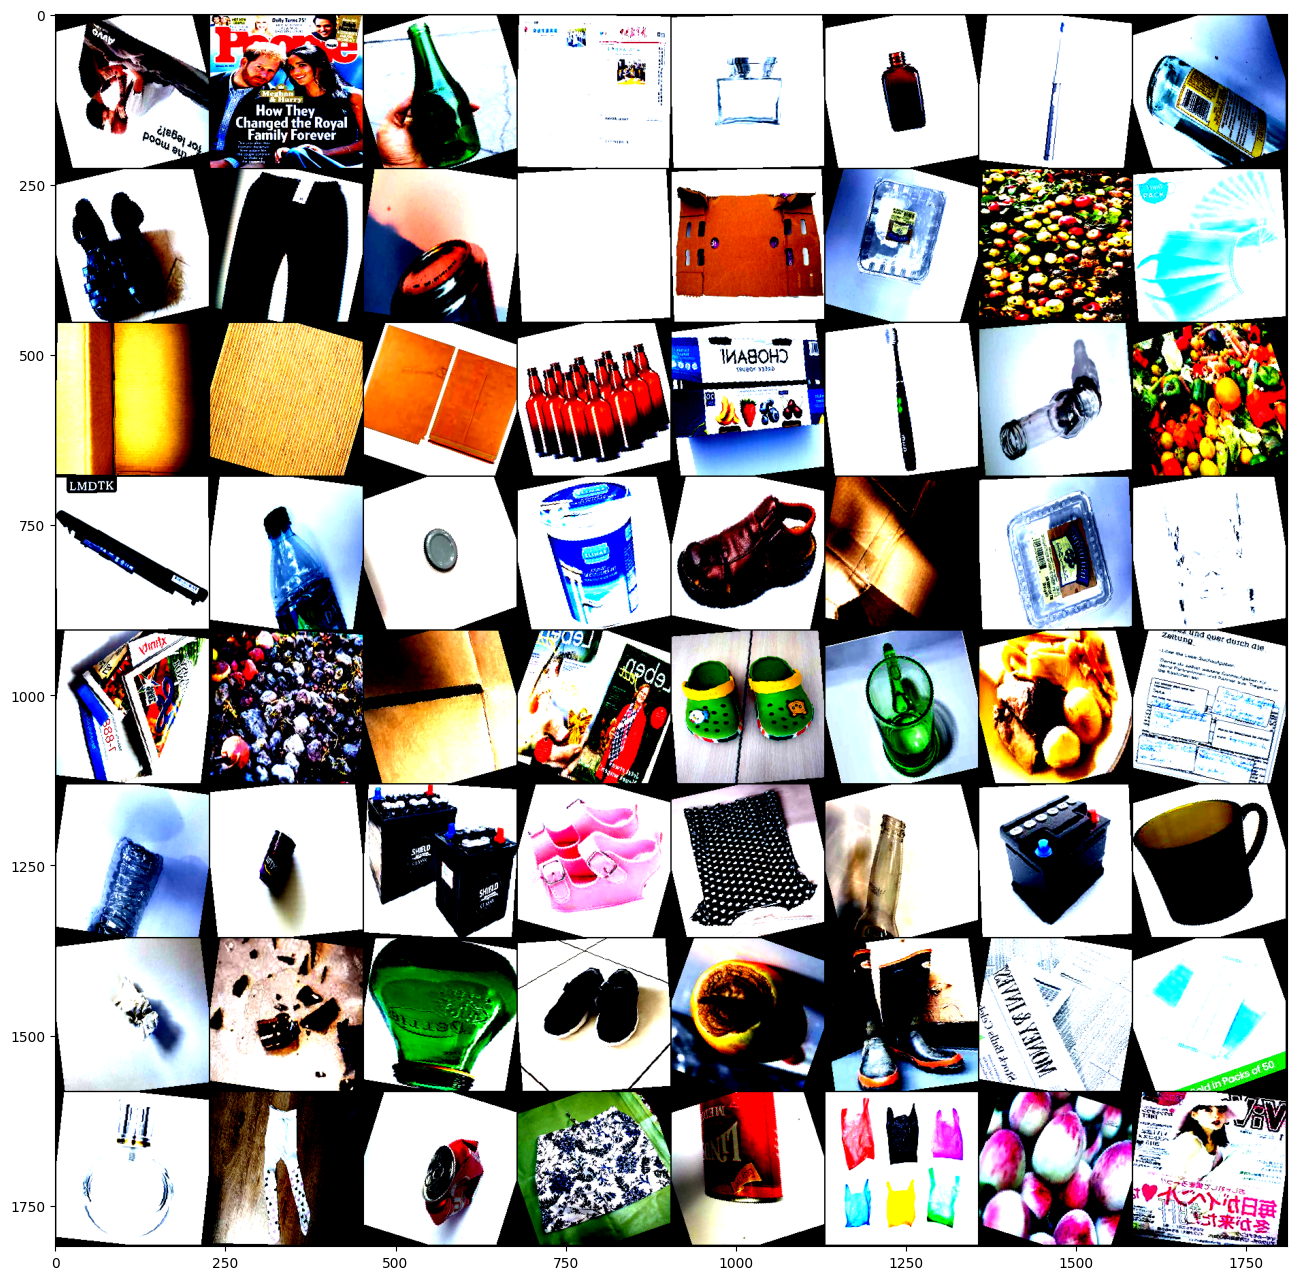

In [ ]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=8)  # images in a row. the default nrow is 8

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))); # we see that dataloader has shuffle the images

# Model Building

In [ ]:
num_classes = 12

net = torchvision.models.vgg16(pretrained=True)

# Freeze all layers (final layer changed later)
for p in net.parameters():
    p.requires_grad = False

# change the final layer (this time soft-coded!)
net.classifier[-1] = nn.Linear(net.classifier[-1].in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 288MB/s]


In [ ]:
from torchsummary import summary
summary(net.to(device),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
numepochs = 5
learning_rate_alpha = 0.001


# push model to GPU
net.to(device)

# loss function
lossfun = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate_alpha) # load hyperparameter

# initialize losses
losses    = torch.zeros(numepochs)
trainAcc  = []
testAcc   = []


# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  net.train() ## .train will backprop
  batchAcc  = []
  batchLoss = []
  for X,y in train_loader:

    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this batch
    batchLoss.append(loss.item())

    yHat = yHat.cpu()
    y = y.cpu()

    # compute accuracy
    matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
    matchesNumeric = matches.float()             # convert to numbers (0/1)
    accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
    batchAcc.append( accuracyPct )               # add to list of accuracies
  # end of batch loop...

  # now that we've trained through the batches, get their average training accuracy
  trainAcc.append( np.mean(batchAcc) )

  # and get average losses across the batches
  losses[epochi] = np.mean(batchLoss)

  # test accuracy
  net.eval() ##.eval = not calculate gradient anymore
  X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # New!
  X = X.to(device) #to(device)
  y = y.to(device) #to(device)

  with torch.no_grad(): # deactivates autograd
    yHat = net(X)

  # New! bring outputs back
  yHat = yHat.cpu()
  y = y.cpu()

  # compare the following really long line of code to the training accuracy lines
  testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  if (epochi % 1) == 0:

      print(f' epochs : {epochi}  loss : {loss : 2.2f}  trainAcc : {trainAcc[epochi]}  testAcc : {testAcc[epochi]}')
# end epochs

 epochs : 0  loss :  0.66  trainAcc : 77.52899169921875  testAcc : 84.375
 epochs : 1  loss :  0.69  trainAcc : 83.75482940673828  testAcc : 89.0625
 epochs : 2  loss :  0.47  trainAcc : 84.60051727294922  testAcc : 92.1875
 epochs : 3  loss :  0.42  trainAcc : 85.21263122558594  testAcc : 95.3125
 epochs : 4  loss :  0.47  trainAcc : 85.38176727294922  testAcc : 95.3125


## Save the Model

In [ ]:
PATH = 'model_vgg16'
torch.save(net.state_dict(), PATH)

## Performance Evaluation

In [ ]:
def visualization(losses, trainAcc,testAcc, model_name):

  fig, ax = plt.subplots(1,2, figsize = (18,6)) # row = 1, col = 2

  # first plot: Training Loss v. Epochs
  ax[0].plot(losses, label = 'Train Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Training Loss')
  ax[0].legend(fontsize = 15)
  ax[0].set_title('Training Loss v. Epochs')

  # second plot: Training & Testing Accuracy v. Epochs
  ax[1].plot(trainAcc, label = 'Train accuracy')
  ax[1].plot(testAcc, label = 'Test accuracy') #test_accuracy starts from 100?
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy (%)')
  # print the latest accuracy [-1]
  ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%')
  ax[1].legend(fontsize = 15)

  plt.show()

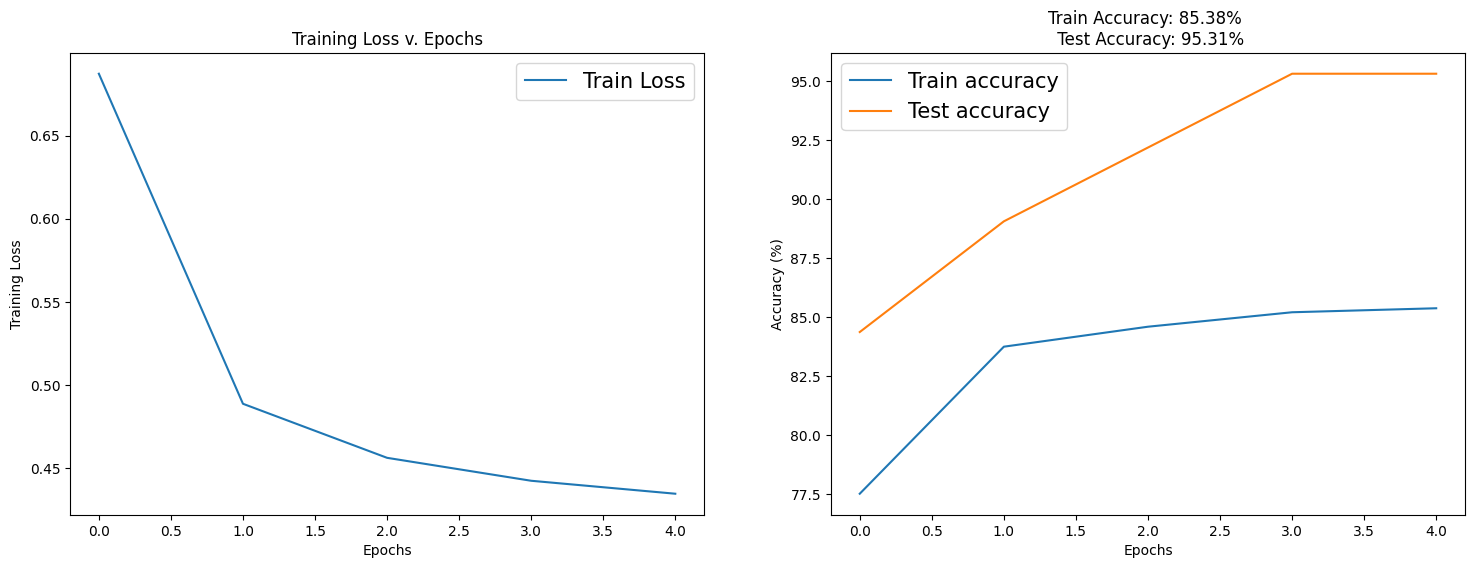

In [ ]:
visualization(losses=losses, trainAcc = trainAcc, testAcc = testAcc, model_name='VGG16')